In [ ]:
# Name: Muhammad Junaid Iftikhar
# Roll Number: Ezi-ML-B1-161
# TASK 10 Transfer Learning

#@title Install required packages
!pip install tensorflow keras numpy pandas matplotlib seaborn scikit-learn pillow opencv-python kagglehub grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=851e7880f58595df378384228043f9bda6a58737c91a4c5640d1446999addb35
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
#@title Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
#@title Install opendatasets
!pip install opendatasets

In [ ]:
#@title Set the correct dataset path
dataset_path = "/content/pneumonia-tb-dataset/Combined_Dataset_12856/Combined_Dataset_12856"
print(f"Dataset path: {dataset_path}")
print(f"Directory exists: {os.path.exists(dataset_path)}")

# List contents
!ls -la "{dataset_path}"

Dataset path: /content/pneumonia-tb-dataset/Combined_Dataset_12856/Combined_Dataset_12856
Directory exists: True
total 20
drwxr-xr-x 5 root root 4096 Sep 19 19:13 .
drwxr-xr-x 3 root root 4096 Sep 19 19:13 ..
drwxr-xr-x 5 root root 4096 Sep 19 19:13 Test
drwxr-xr-x 5 root root 4096 Sep 19 19:13 Train
drwxr-xr-x 5 root root 4096 Sep 19 19:13 Validate


In [ ]:
#@title Download dataset using opendatasets
import opendatasets as od

# Download the dataset
od.download("https://www.kaggle.com/datasets/shaikhborhanuddin/pneumonia-tb-dataset")

print("Dataset downloaded successfully!")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: junaid1729
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/shaikhborhanuddin/pneumonia-tb-dataset


100%|██████████| 86.2M/86.2M [00:00<00:00, 1.02GB/s]

Dataset downloaded successfully!


In [ ]:
#@title Explore the directory structure
import os

def explore_directory(path, indent=0):
    """Recursively explore directory structure"""
    items = os.listdir(path)
    for item in items:
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            print('  ' * indent + f' {item}/')
            explore_directory(item_path, indent + 1)
        else:
            if item.lower().endswith(('.png', '.jpg', '.jpeg')):
                print('  ' * indent + f'  {item}')

print("Exploring dataset structure:")
explore_directory(dataset_path)

Streaming output truncated to the last 5000 lines.
      person383_bacteria_1747.jpeg
      person1689_bacteria_4473.jpeg
      person1368_virus_2354.jpeg
      person1648_bacteria_4375.jpeg
      person1130_bacteria_3072.jpeg
      person85_bacteria_422.jpeg
      person1182_virus_2017.jpeg
      person1241_virus_2106.jpeg
      person1952_bacteria_4883.jpeg
      person996_bacteria_2924.jpeg
      person348_bacteria_1601.jpeg
      person977_virus_1652.jpeg
      person485_virus_988.jpeg
      person409_virus_818.jpeg
      person718_bacteria_2620.jpeg
      person1559_bacteria_4067.jpeg
      person1308_bacteria_3285.jpeg
      person396_bacteria_1796.jpeg
      person1429_bacteria_3690.jpeg
      person530_bacteria_2233.jpeg
      person520_bacteria_2205.jpeg
      person478_bacteria_2035.jpeg
      person1527_virus_2661.jpeg
      person1507_bacteria_3942.jpeg
      person634_bacteria_2525.jpeg
      person1288_bacteria_3251.jpeg
      person1018_bacteria_2949.jpeg
      person835

In [ ]:
#@title Data Preprocessing and Augmentation
IMG_SIZE = (300, 300)
BATCH_SIZE = 32

# Define the paths for training, validation, and test directories
train_dir = os.path.join(dataset_path, 'Train')
val_dir = os.path.join(dataset_path, 'Validate')
test_dir = os.path.join(dataset_path, 'Test')


# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.9, 1.1]
)

# Only rescaling for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

# Get class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

print("Class names:", train_generator.class_indices)
print("Class weights:", class_weights_dict)

Found 11557 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 1284 images belonging to 3 classes.
Class names: {'Normal': 0, 'Pneumonia': 1, 'TB': 2}
Class weights: {0: np.float64(0.8429613420860685), 1: np.float64(1.0029506204981342), 2: np.float64(1.2245179063360883)}


Class names: ['Normal', 'Pneumonia', 'TB']
Sample training images:


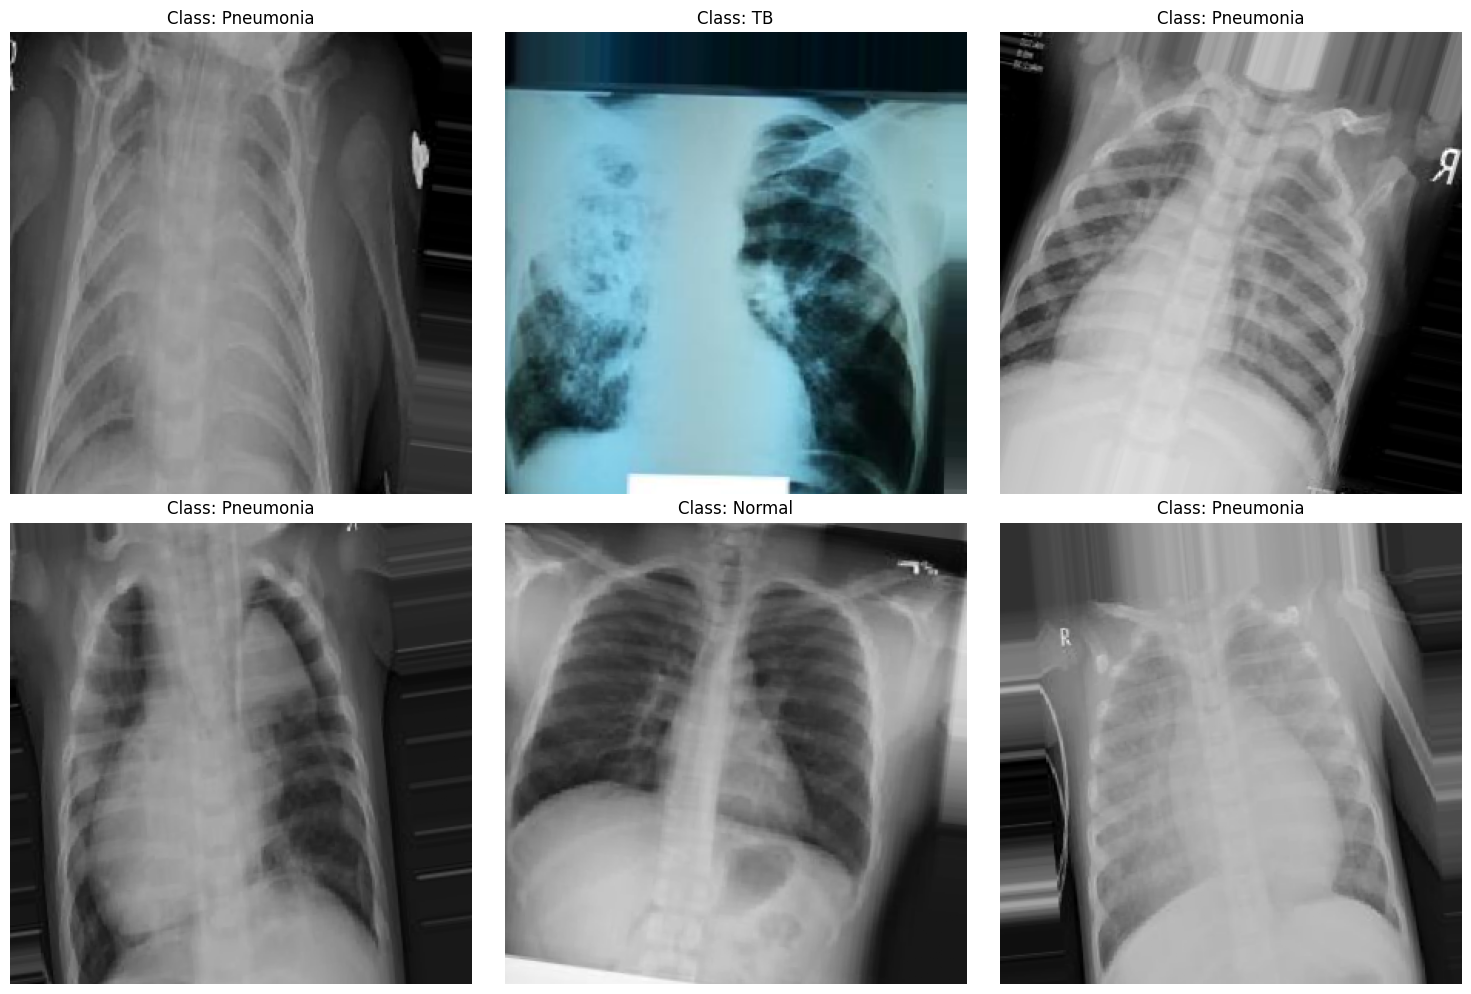

In [ ]:
#@title Visualize sample images from each class
def plot_sample_images(generator, class_names):
    """Plot sample images from the generator"""
    images, labels = next(generator)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for i in range(6):
        row = i // 3
        col = i % 3
        axes[row, col].imshow(images[i])
        class_idx = np.argmax(labels[i])
        axes[row, col].set_title(f'Class: {class_names[class_idx]}')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Get class names from generator
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

# Plot sample images
print("Sample training images:")
plot_sample_images(train_generator, class_names)

In [ ]:
#@title Build EfficientNet Model with Transfer Learning
def create_model():
    # Load pre-trained EfficientNetB3 without top layers
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        pooling='avg'
    )

    # Freeze the base model initially
    base_model.trainable = False

    # Create custom head
    inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs, outputs)

    return model, base_model

model, base_model = create_model()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,802 (42.64 MB)

 Trainable params: 394,755 (1.51 MB)

 Non-trainable params: 10,784,047 (41.14 MB)

In [ ]:
#@title Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

In [ ]:
#@title First Training Phase: Train only the head
print("First training phase: Training only the head...")
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

First training phase: Training only the head...
Epoch 1/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.3313 - auc: 0.4972 - loss: 1.4219 - precision: 0.3277 - recall: 0.2192
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to best_model.h5


362/362 ━━━━━━━━━━━━━━━━━━━━ 402s 959ms/step - accuracy: 0.3313 - auc: 0.4972 - loss: 1.4215 - precision: 0.3277 - recall: 0.2190 - val_accuracy: 0.6000 - val_auc: 0.6767 - val_loss: 1.0875 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.3338 - auc: 0.5033 - loss: 1.1222 - precision: 0.3718 - recall: 0.0220
Epoch 2: val_accuracy did not improve from 0.60000
362/362 ━━━━━━━━━━━━━━━━━━━━ 292s 805ms/step - accuracy: 0.3338 - auc: 0.5033 - loss: 1.1221 - precision: 0.3718 - recall: 0.0219 - val_accuracy: 0.3333 - val_auc: 0.6133 - val_loss: 1.0866 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.3412 - auc: 0.5190 - loss: 1.1021 - precision: 0.3137 - recall: 0.0012
Epoch 3: val_accuracy did not improve from 0.60000
362/362 ━━━━━━━━━━━━━━━━━━━━ 297s 820ms/step - accuracy: 0.3412 - auc: 0.5190 - loss: 

362/362 ━━━━━━━━━━━━━━━━━━━━ 279s 772ms/step - accuracy: 0.3351 - auc: 0.5117 - loss: 1.1010 - precision: 0.0676 - recall: 9.5104e-05 - val_accuracy: 0.6667 - val_auc: 0.7456 - val_loss: 1.0793 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 17/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.3462 - auc: 0.5114 - loss: 1.1019 - precision: 0.3577 - recall: 2.1988e-04
Epoch 17: val_accuracy did not improve from 0.66667
362/362 ━━━━━━━━━━━━━━━━━━━━ 275s 759ms/step - accuracy: 0.3462 - auc: 0.5113 - loss: 1.1019 - precision: 0.3577 - recall: 2.1952e-04 - val_accuracy: 0.5333 - val_auc: 0.7967 - val_loss: 1.0835 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 18/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.3271 - auc: 0.4985 - loss: 1.1019 - precision: 0.1894 - recall: 8.4711e-05
Epoch 18: val_accuracy did not improve from 0.66667
362/362 ━━━━━━━━━━━━━━━━━━━━ 273s 754ms/step - accuracy: 0.3271 - 

In [ ]:
#@title Second Training Phase: Fine-tuning
print("Unfreezing some layers for fine-tuning...")
# Unfreeze the top layers of the base model
base_model.trainable = True

# Freeze the first 200 layers and unfreeze the rest
for layer in base_model.layers[:200]:
    layer.trainable = False
for layer in base_model.layers[200:]:
    layer.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

# Continue training
print("Second training phase: Fine-tuning...")
history_fine = model.fit(
    train_generator,
    epochs=30,
    initial_epoch=len(history.history['loss']),
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

Unfreezing some layers for fine-tuning...
Second training phase: Fine-tuning...
Epoch 21/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.3790 - auc: 0.5567 - loss: 1.1379 - precision: 0.4044 - recall: 0.1513
Epoch 21: val_accuracy did not improve from 0.66667
362/362 ━━━━━━━━━━━━━━━━━━━━ 422s 955ms/step - accuracy: 0.3792 - auc: 0.5568 - loss: 1.1378 - precision: 0.4046 - recall: 0.1515 - val_accuracy: 0.5333 - val_auc: 0.6378 - val_loss: 1.0571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 22/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.5260 - auc: 0.7236 - loss: 0.9429 - precision: 0.6298 - recall: 0.3306
Epoch 22: val_accuracy did not improve from 0.66667
362/362 ━━━━━━━━━━━━━━━━━━━━ 294s 811ms/step - accuracy: 0.5260 - auc: 0.7236 - loss: 0.9428 - precision: 0.6298 - recall: 0.3307 - val_accuracy: 0.6667 - val_auc: 0.8600 - val_loss: 0.6926 - val_precision: 0.6923 - val_recall: 0.6000 - learning_rate: 1.0000e-05
Ep

362/362 ━━━━━━━━━━━━━━━━━━━━ 292s 806ms/step - accuracy: 0.5988 - auc: 0.8012 - loss: 0.8179 - precision: 0.7093 - recall: 0.4580 - val_accuracy: 0.7333 - val_auc: 0.8967 - val_loss: 0.5890 - val_precision: 0.7857 - val_recall: 0.7333 - learning_rate: 1.0000e-05
Epoch 24/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.6411 - auc: 0.8372 - loss: 0.7450 - precision: 0.7315 - recall: 0.5196
Epoch 24: val_accuracy improved from 0.73333 to 0.80000, saving model to best_model.h5


362/362 ━━━━━━━━━━━━━━━━━━━━ 291s 803ms/step - accuracy: 0.6411 - auc: 0.8372 - loss: 0.7450 - precision: 0.7315 - recall: 0.5196 - val_accuracy: 0.8000 - val_auc: 0.8889 - val_loss: 0.5968 - val_precision: 0.8000 - val_recall: 0.8000 - learning_rate: 1.0000e-05
Epoch 25/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.6723 - auc: 0.8588 - loss: 0.6987 - precision: 0.7642 - recall: 0.5708
Epoch 25: val_accuracy did not improve from 0.80000
362/362 ━━━━━━━━━━━━━━━━━━━━ 291s 805ms/step - accuracy: 0.6723 - auc: 0.8588 - loss: 0.6987 - precision: 0.7641 - recall: 0.5708 - val_accuracy: 0.8000 - val_auc: 0.9600 - val_loss: 0.4054 - val_precision: 0.8000 - val_recall: 0.8000 - learning_rate: 1.0000e-05
Epoch 26/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.6812 - auc: 0.8693 - loss: 0.6729 - precision: 0.7594 - recall: 0.5869
Epoch 26: val_accuracy improved from 0.80000 to 0.93333, saving model to best_model.h5


362/362 ━━━━━━━━━━━━━━━━━━━━ 290s 802ms/step - accuracy: 0.6812 - auc: 0.8694 - loss: 0.6729 - precision: 0.7594 - recall: 0.5869 - val_accuracy: 0.9333 - val_auc: 0.9856 - val_loss: 0.2419 - val_precision: 0.9333 - val_recall: 0.9333 - learning_rate: 1.0000e-05
Epoch 27/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.7164 - auc: 0.8920 - loss: 0.6156 - precision: 0.7855 - recall: 0.6402
Epoch 27: val_accuracy did not improve from 0.93333
362/362 ━━━━━━━━━━━━━━━━━━━━ 295s 815ms/step - accuracy: 0.7164 - auc: 0.8920 - loss: 0.6155 - precision: 0.7854 - recall: 0.6403 - val_accuracy: 0.9333 - val_auc: 0.9822 - val_loss: 0.2461 - val_precision: 0.9333 - val_recall: 0.9333 - learning_rate: 1.0000e-05
Epoch 28/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.7264 - auc: 0.8962 - loss: 0.6040 - precision: 0.7844 - recall: 0.6658
Epoch 28: val_accuracy did not improve from 0.93333
362/362 ━━━━━━━━━━━━━━━━━━━━ 291s 805ms/step - accuracy: 0.7264 - auc: 0.8962 - loss: 0.60

362/362 ━━━━━━━━━━━━━━━━━━━━ 295s 814ms/step - accuracy: 0.7412 - auc: 0.9054 - loss: 0.5748 - precision: 0.7875 - recall: 0.6853 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1992 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 30/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.7592 - auc: 0.9179 - loss: 0.5375 - precision: 0.8029 - recall: 0.7104
Epoch 30: val_accuracy did not improve from 1.00000
362/362 ━━━━━━━━━━━━━━━━━━━━ 294s 813ms/step - accuracy: 0.7592 - auc: 0.9179 - loss: 0.5375 - precision: 0.8029 - recall: 0.7104 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1931 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 28.


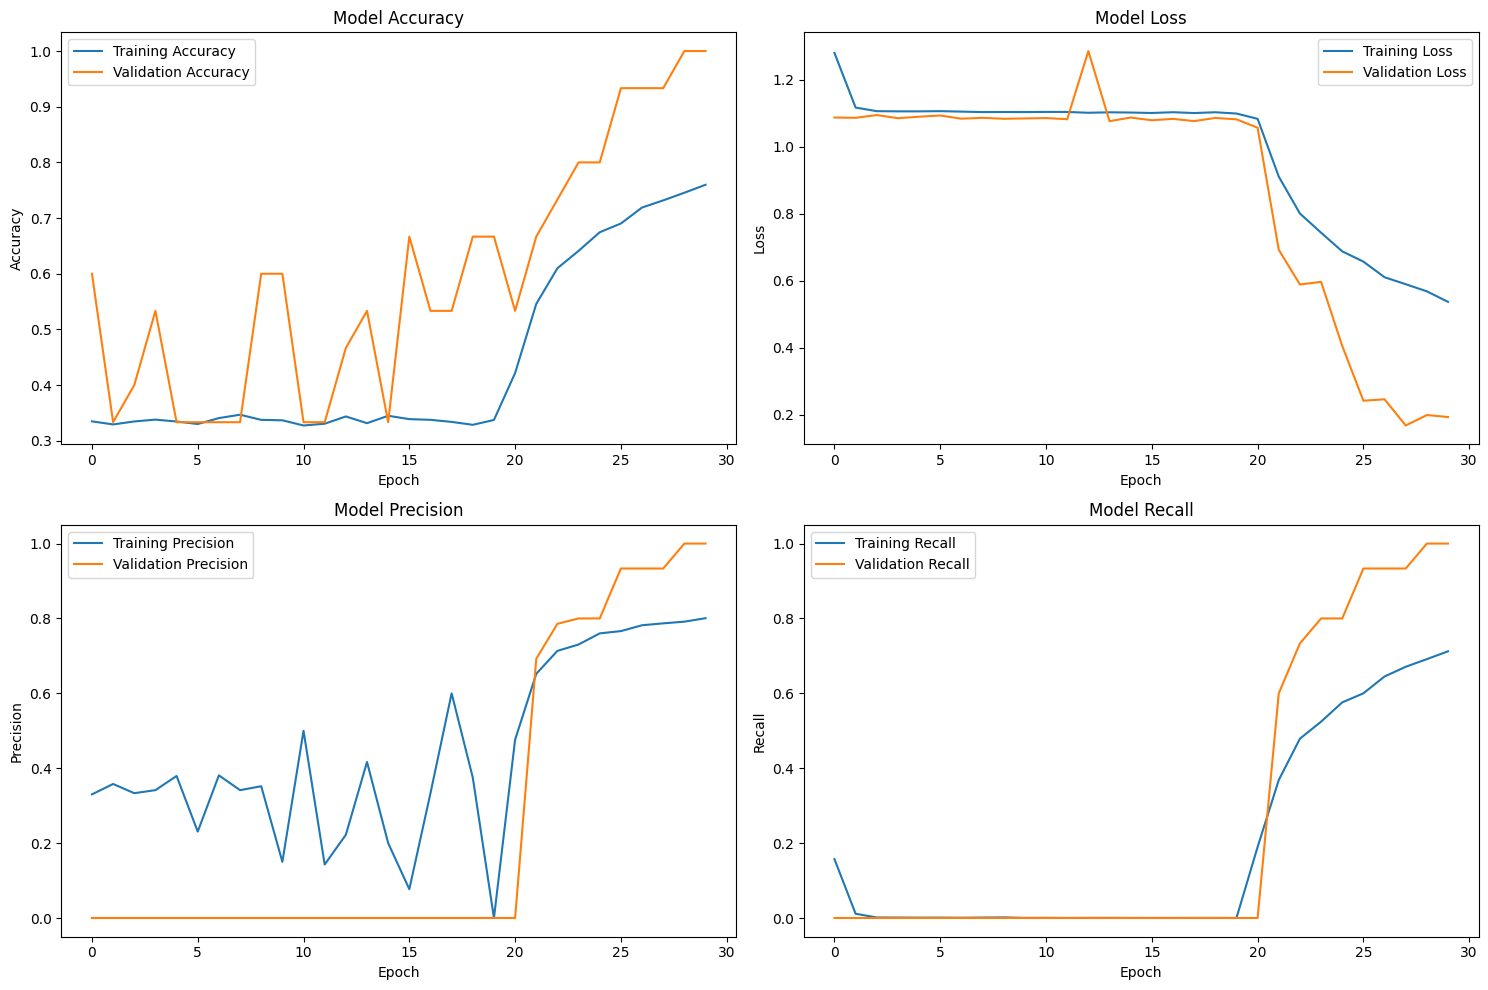

In [ ]:
#@title Combine training histories and plot results
def combine_histories(initial_history, fine_history):
    combined_history = {}
    for key in initial_history.history.keys():
        combined_history[key] = initial_history.history[key] + fine_history.history[key]
    return combined_history

combined_history = combine_histories(history, history_fine)

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(combined_history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(combined_history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Loss
axes[0, 1].plot(combined_history['loss'], label='Training Loss')
axes[0, 1].plot(combined_history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Precision
axes[1, 0].plot(combined_history['precision'], label='Training Precision')
axes[1, 0].plot(combined_history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()

# Recall
axes[1, 1].plot(combined_history['recall'], label='Training Recall')
axes[1, 1].plot(combined_history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
#@title Evaluate the model on test set
print("Evaluating on test set...")
test_results = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")
print(f"Test AUC: {test_results[4]:.4f}")

Evaluating on test set...
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 497ms/step - accuracy: 0.9092 - auc: 0.9756 - loss: 0.3471 - precision: 0.9151 - recall: 0.9037
Test Loss: 0.2582
Test Accuracy: 0.9237
Test Precision: 0.9292
Test Recall: 0.9198
Test AUC: 0.9875


41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 385ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.91      0.92      0.91       508
   Pneumonia       0.90      0.89      0.90       427
          TB       0.97      0.98      0.98       349

    accuracy                           0.92      1284
   macro avg       0.93      0.93      0.93      1284
weighted avg       0.92      0.92      0.92      1284



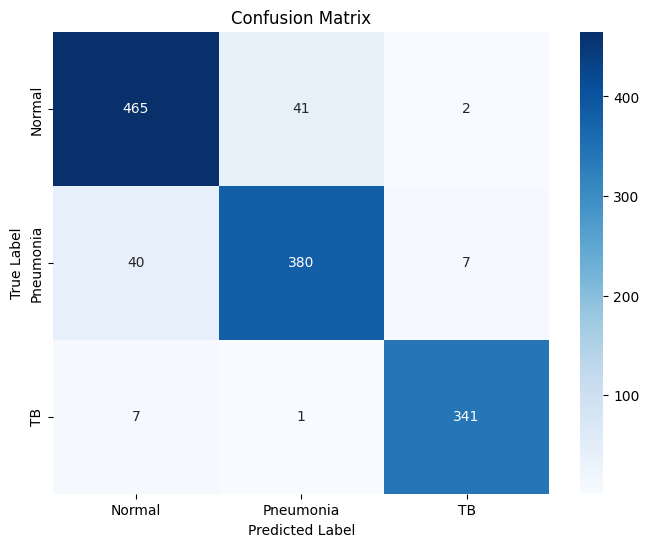

In [ ]:
#@title Generate predictions and classification report
# Get true labels and predictions
test_generator.reset()
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
#@title Implement Grad-CAM for model interpretability
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 5.1 MB/s eta 0:00:00


Sample Predictions on Test Set:


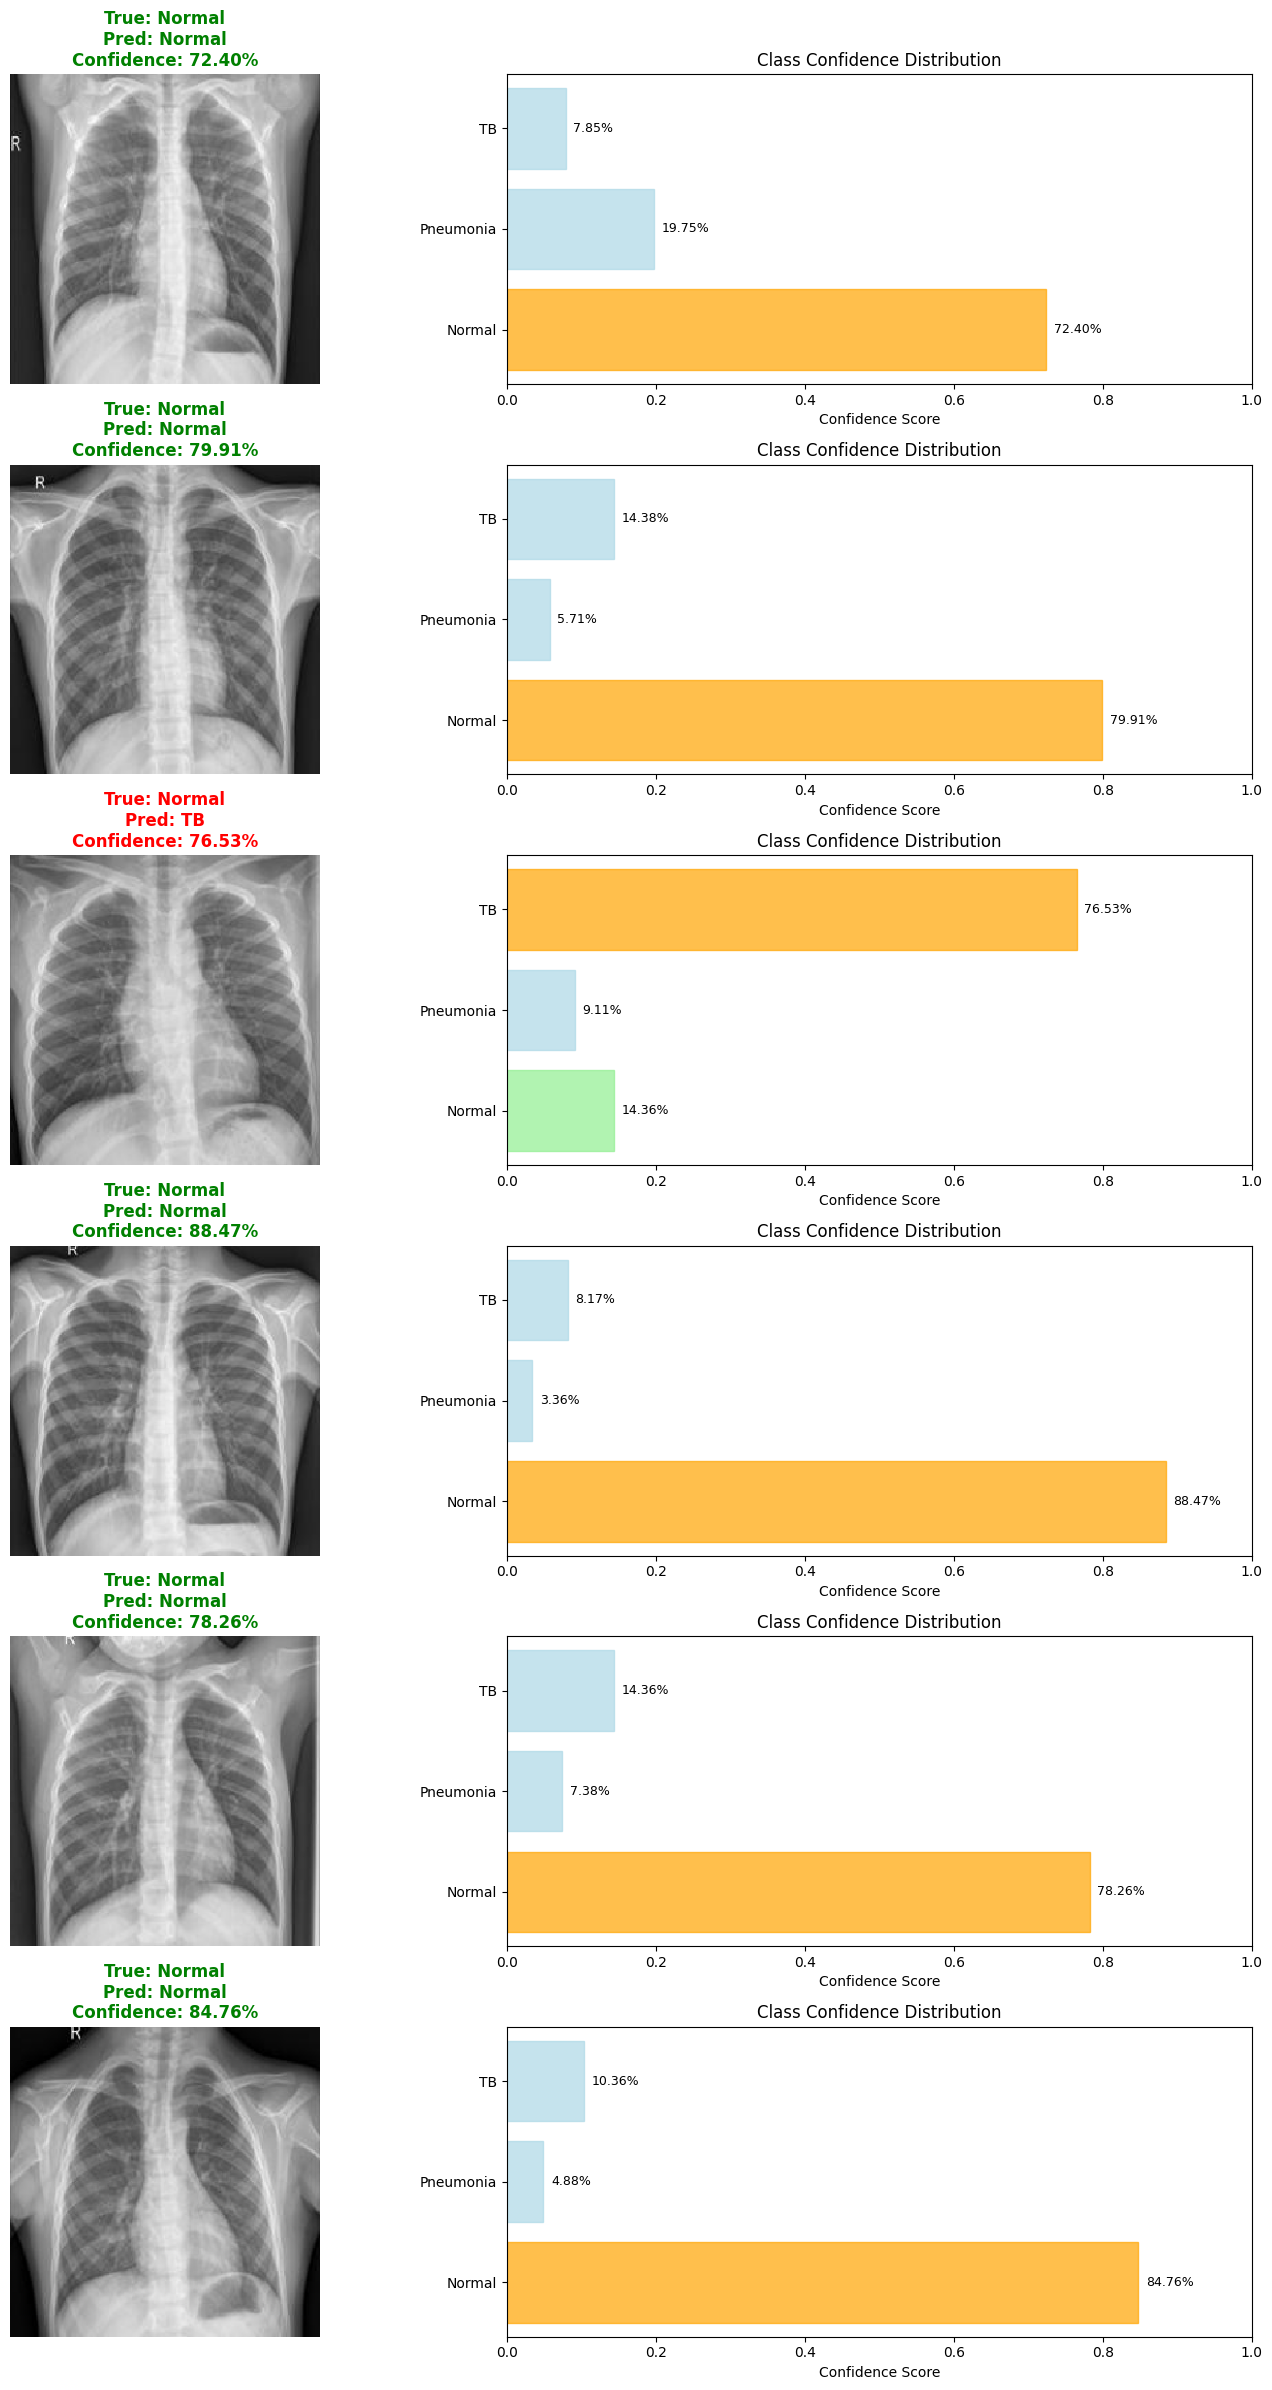

In [ ]:
#@title Fixed Visualization - Separate Image and Confidence Plots
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions_fixed(generator, model, class_names, num_samples=12):
    """Visualize sample images with their predictions and confidence scores"""

    # Get a batch of images and true labels
    generator.reset()
    images, true_labels = next(generator)

    # Make predictions
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)
    true_classes = np.argmax(true_labels, axis=1)

    # Create subplots with better layout
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 4*num_samples))

    for i in range(min(num_samples, len(images))):
        # Display image on left subplot
        axes[i, 0].imshow(images[i])

        # Get prediction info
        true_class = class_names[true_classes[i]]
        predicted_class = class_names[predicted_classes[i]]
        confidence = confidence_scores[i]

        # Set title with color coding
        color = 'green' if true_class == predicted_class else 'red'
        axes[i, 0].set_title(
            f'True: {true_class}\nPred: {predicted_class}\nConfidence: {confidence:.2%}',
            color=color,
            fontsize=12,
            fontweight='bold'
        )
        axes[i, 0].axis('off')

        # Add confidence bars on right subplot
        y_pos = np.arange(len(class_names))
        bars = axes[i, 1].barh(y_pos, predictions[i], alpha=0.7)

        # Color the bars based on prediction
        for j, bar in enumerate(bars):
            if j == predicted_classes[i]:
                bar.set_color('orange')  # Highlight predicted class
            elif j == true_classes[i]:
                bar.set_color('lightgreen')  # Highlight true class
            else:
                bar.set_color('lightblue')

        axes[i, 1].set_yticks(y_pos)
        axes[i, 1].set_yticklabels(class_names, fontsize=10)
        axes[i, 1].set_xlim(0, 1)
        axes[i, 1].set_xlabel('Confidence Score', fontsize=10)
        axes[i, 1].set_title('Class Confidence Distribution', fontsize=12)

        # Add confidence values on bars
        for j, (bar, prob) in enumerate(zip(bars, predictions[i])):
            width = bar.get_width()
            axes[i, 1].text(width + 0.01, bar.get_y() + bar.get_height()/2,
                          f'{prob:.2%}', ha='left', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# Visualize predictions on test set
print("Sample Predictions on Test Set:")
visualize_predictions_fixed(test_generator, model, class_names, num_samples=6)

Grid Layout Predictions:


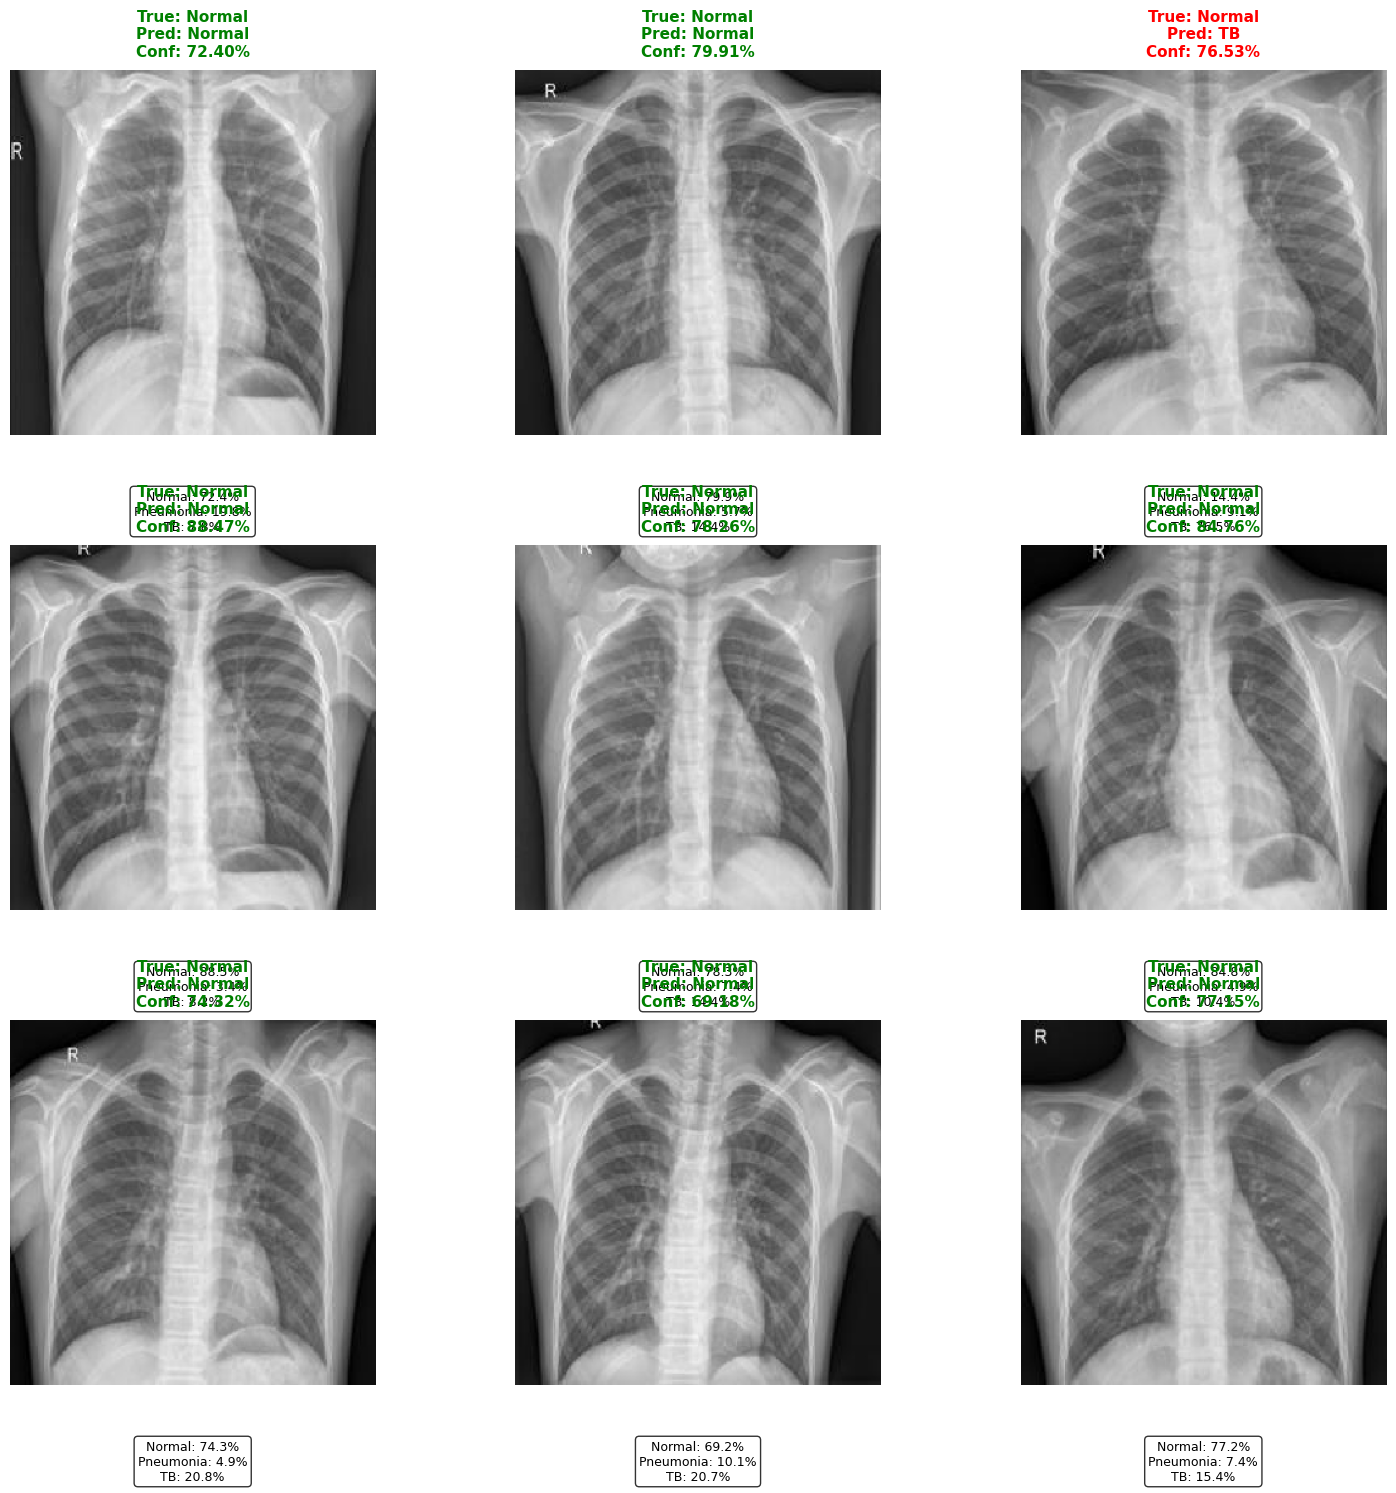

In [ ]:
#@title Alternative: Grid Layout with Larger Images
def visualize_predictions_grid(generator, model, class_names, num_samples=9):
    """Visualize predictions in a grid layout with larger images"""

    # Get a batch of images and true labels
    generator.reset()
    images, true_labels = next(generator)

    # Make predictions
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)
    true_classes = np.argmax(true_labels, axis=1)

    # Create a grid layout
    grid_size = int(np.ceil(np.sqrt(num_samples)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(min(num_samples, len(images))):
        # Display image
        axes[i].imshow(images[i])

        # Get prediction info
        true_class = class_names[true_classes[i]]
        predicted_class = class_names[predicted_classes[i]]
        confidence = confidence_scores[i]

        # Set title with color coding
        color = 'green' if true_class == predicted_class else 'red'
        title = f'True: {true_class}\nPred: {predicted_class}\nConf: {confidence:.2%}'
        axes[i].set_title(title, color=color, fontsize=11, fontweight='bold', pad=10)

        # Add confidence info as text below image
        conf_text = "\n".join([f"{cls}: {prob:.1%}"
                             for cls, prob in zip(class_names, predictions[i])])
        axes[i].text(0.5, -0.15, conf_text, transform=axes[i].transAxes,
                   fontsize=9, ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        axes[i].axis('off')

    # Hide empty subplots
    for i in range(num_samples, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    plt.show()

print("Grid Layout Predictions:")
visualize_predictions_grid(test_generator, model, class_names, num_samples=9)

Confidence-based Visualization:


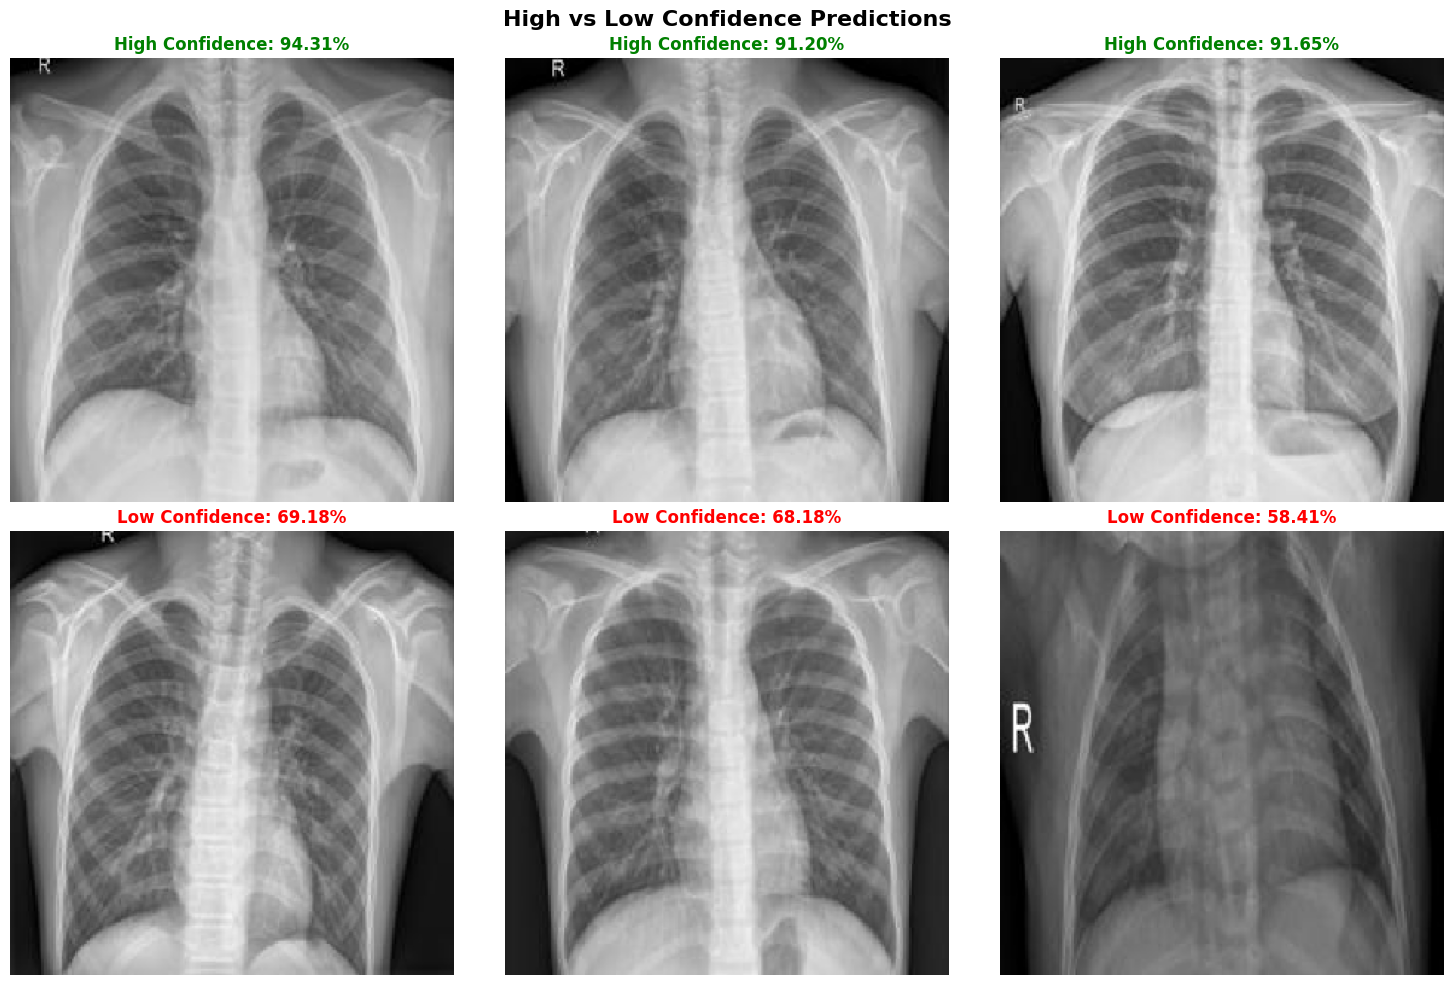

Insights:
High confidence examples: Clear, typical patterns
Low confidence examples: Ambiguous, noisy, or unusual patterns


In [ ]:
#@title Confidence-based Feature Visualization
def confidence_based_visualization(model, generator, class_names):
    """Visualize images that get high vs low confidence"""

    generator.reset()
    high_confidence_images = []
    low_confidence_images = []
    high_conf_scores = []
    low_conf_scores = []

    # Collect samples
    for i in range(min(20, len(generator))):  # Check first 20 batches
        images, labels = next(generator)
        predictions = model.predict(images, verbose=0)
        confidences = np.max(predictions, axis=1)

        for j, (img, conf) in enumerate(zip(images, confidences)):
            if conf > 0.9 and len(high_confidence_images) < 3:
                high_confidence_images.append(img)
                high_conf_scores.append(conf)
            elif conf < 0.7 and len(low_confidence_images) < 3:
                low_confidence_images.append(img)
                low_conf_scores.append(conf)

            if len(high_confidence_images) >= 3 and len(low_confidence_images) >= 3:
                break

    # Visualize
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # High confidence examples
    for i, (img, conf) in enumerate(zip(high_confidence_images, high_conf_scores)):
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'High Confidence: {conf:.2%}', fontweight='bold', fontsize=12, color='green')
        axes[0, i].axis('off')

    # Low confidence examples
    for i, (img, conf) in enumerate(zip(low_confidence_images, low_conf_scores)):
        axes[1, i].imshow(img)
        axes[1, i].set_title(f'Low Confidence: {conf:.2%}', fontweight='bold', fontsize=12, color='red')
        axes[1, i].axis('off')

    plt.suptitle('High vs Low Confidence Predictions', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

    print("Insights:")
    print(f"High confidence examples: Clear, typical patterns")
    print(f"Low confidence examples: Ambiguous, noisy, or unusual patterns")

print("Confidence-based Visualization:")
confidence_based_visualization(model, test_generator, class_names)

Confidence Distribution Analysis:


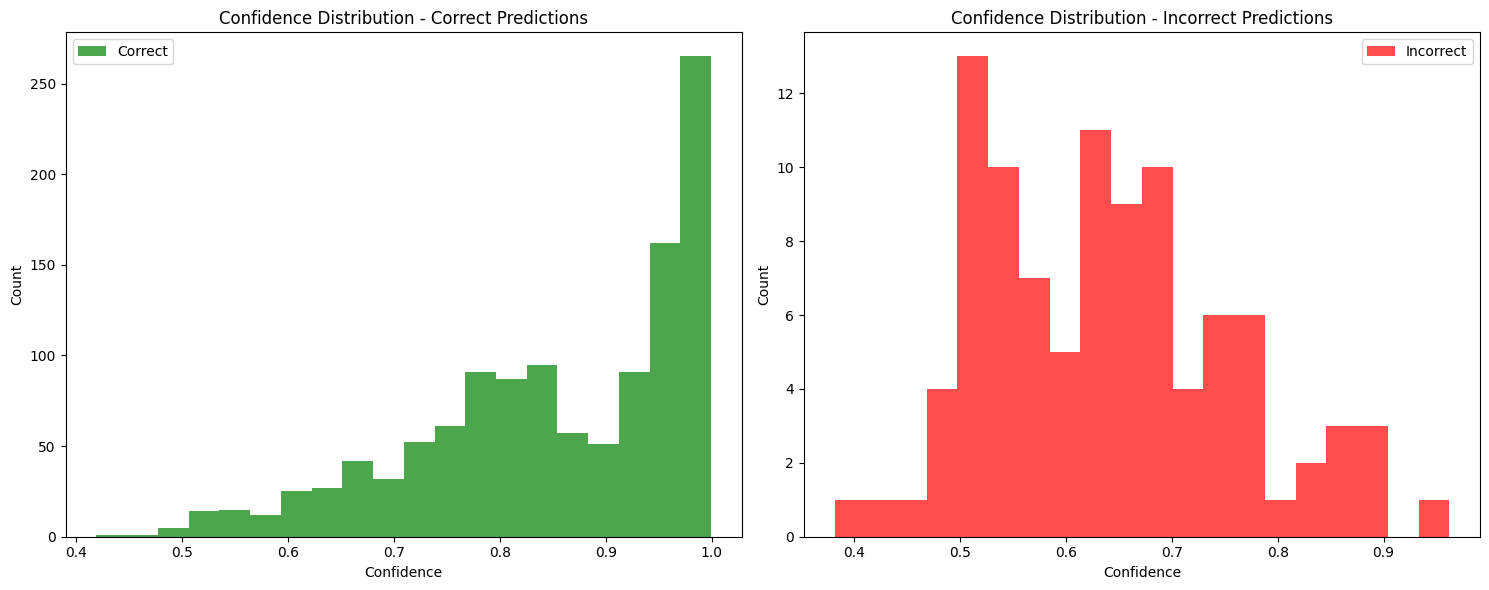

Confidence Statistics:
Average confidence (correct): 85.11%
Average confidence (incorrect): 63.92%
Correct predictions: 1186
Incorrect predictions: 98
Accuracy: 92.37%


In [ ]:
#@title Confidence Distribution Analysis (Safe)
def safe_confidence_analysis(generator, model, class_names):
    """Analyze confidence distribution without layer access"""

    generator.reset()
    all_probs = []
    all_true = []
    all_pred = []

    # Collect predictions for entire test set
    for i in range(len(generator)):
        images, labels = next(generator)
        probs = model.predict(images, verbose=0)
        preds = np.argmax(probs, axis=1)
        trues = np.argmax(labels, axis=1)

        all_probs.extend(probs)
        all_true.extend(trues)
        all_pred.extend(preds)

    all_probs = np.array(all_probs)
    all_true = np.array(all_true)
    all_pred = np.array(all_pred)

    # Calculate confidence metrics
    correct_mask = all_true == all_pred
    correct_confidences = np.max(all_probs[correct_mask], axis=1)
    incorrect_confidences = np.max(all_probs[~correct_mask], axis=1)

    # Plot confidence distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Correct predictions confidence
    ax1.hist(correct_confidences, bins=20, alpha=0.7, color='green', label='Correct')
    ax1.set_xlabel('Confidence')
    ax1.set_ylabel('Count')
    ax1.set_title('Confidence Distribution - Correct Predictions')
    ax1.legend()

    # Incorrect predictions confidence
    ax2.hist(incorrect_confidences, bins=20, alpha=0.7, color='red', label='Incorrect')
    ax2.set_xlabel('Confidence')
    ax2.set_ylabel('Count')
    ax2.set_title('Confidence Distribution - Incorrect Predictions')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("Confidence Statistics:")
    print(f"Average confidence (correct): {np.mean(correct_confidences):.2%}")
    print(f"Average confidence (incorrect): {np.mean(incorrect_confidences):.2%}")
    print(f"Correct predictions: {len(correct_confidences)}")
    print(f"Incorrect predictions: {len(incorrect_confidences)}")
    print(f"Accuracy: {len(correct_confidences)/len(all_true):.2%}")

print("Confidence Distribution Analysis:")
safe_confidence_analysis(test_generator, model, class_names)

Misclassification Patterns:


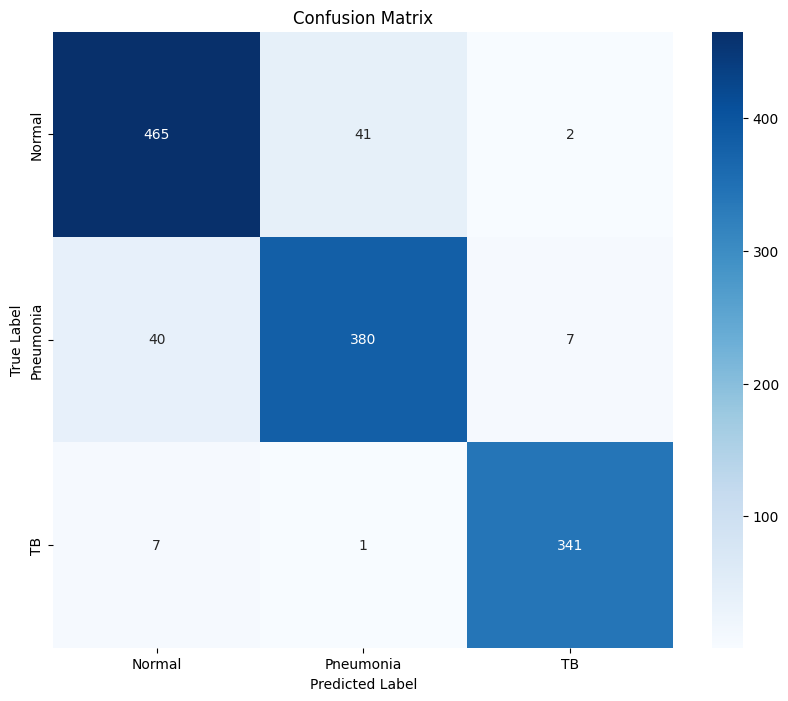


Common Misclassification Patterns:
Normal -> Pneumonia: 41 cases
Normal -> TB: 2 cases
Pneumonia -> Normal: 40 cases
Pneumonia -> TB: 7 cases
TB -> Normal: 7 cases
TB -> Pneumonia: 1 cases


In [ ]:
#@title Misclassification Patterns (Safe)
def misclassification_patterns(generator, model, class_names):
    """Analyze what classes are being confused with each other"""

    generator.reset()
    all_pred = []
    all_true = []

    # Collect all predictions
    for i in range(len(generator)):
        images, labels = next(generator)
        probs = model.predict(images, verbose=0)
        preds = np.argmax(probs, axis=1)
        trues = np.argmax(labels, axis=1)

        all_pred.extend(preds)
        all_true.extend(trues)

    # Create confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(all_true, all_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Analyze common misclassifications
    print("\nCommon Misclassification Patterns:")
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                print(f"{class_names[i]} -> {class_names[j]}: {cm[i, j]} cases")

print("Misclassification Patterns:")
misclassification_patterns(test_generator, model, class_names)

Saliency Map Visualization:


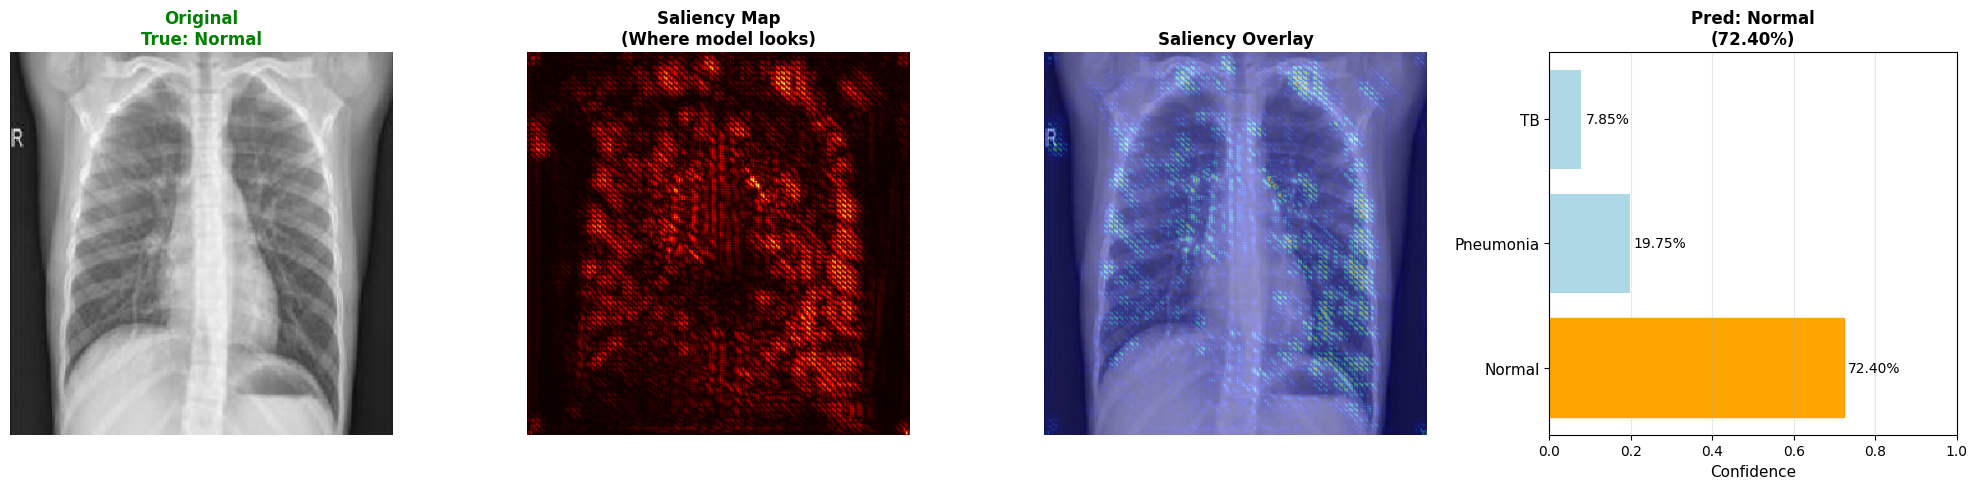

In [ ]:
#@title Saliency Maps Implementation
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_saliency_map(model, image, class_names):
    """Generate saliency map for a single image"""

    # Convert image to tensor
    image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor)
        top_class_idx = tf.argmax(predictions[0])
        top_score = predictions[0][top_class_idx]

    # Get gradients of the top class score with respect to the input image
    gradients = tape.gradient(top_score, image_tensor)

    # Take maximum across color channels
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)[0]

    # Normalize saliency map
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-8)

    return saliency.numpy(), predictions[0].numpy()

def visualize_saliency_map(model, image, class_names, true_class=None):
    """Visualize saliency map with predictions"""

    # Generate saliency map
    saliency, pred_probs = generate_saliency_map(model, image, class_names)
    pred_class_idx = np.argmax(pred_probs)
    pred_class = class_names[pred_class_idx]
    confidence = pred_probs[pred_class_idx]

    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Original image
    axes[0].imshow(image)
    if true_class:
        color = 'green' if true_class == pred_class else 'red'
        axes[0].set_title(f'Original\nTrue: {true_class}', color=color, fontweight='bold', fontsize=12)
    else:
        axes[0].set_title('Original Image', fontweight='bold', fontsize=12)
    axes[0].axis('off')

    # Saliency map
    axes[1].imshow(saliency, cmap='hot')
    axes[1].set_title('Saliency Map\n(Where model looks)', fontweight='bold', fontsize=12)
    axes[1].axis('off')

    # Overlay saliency on image
    saliency_resized = cv2.resize(saliency, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * saliency_resized)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    superimposed = 0.6 * image + 0.4 * heatmap
    axes[2].imshow(superimposed)
    axes[2].set_title('Saliency Overlay', fontweight='bold', fontsize=12)
    axes[2].axis('off')

    # Confidence scores
    y_pos = np.arange(len(class_names))
    bars = axes[3].barh(y_pos, pred_probs, color='lightblue')
    bars[pred_class_idx].set_color('orange')

    axes[3].set_yticks(y_pos)
    axes[3].set_yticklabels(class_names, fontsize=11)
    axes[3].set_xlim(0, 1)
    axes[3].set_xlabel('Confidence', fontsize=11)
    axes[3].set_title(f'Pred: {pred_class}\n({confidence:.2%})', fontweight='bold', fontsize=12)
    axes[3].grid(axis='x', alpha=0.3)

    # Add confidence values
    for i, (bar, prob) in enumerate(zip(bars, pred_probs)):
        axes[3].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                   f'{prob:.2%}', ha='left', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    return saliency, pred_probs

# Test saliency map on a single image
test_generator.reset()
sample_image, sample_label = next(test_generator)
true_class_idx = np.argmax(sample_label[0])
true_class = class_names[true_class_idx]

print("Saliency Map Visualization:")
saliency, probs = visualize_saliency_map(model, sample_image[0], class_names, true_class)